# Python implementations

In [4]:
%matplotlib notebook
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import sys
sys.path.insert(0, '../src/')
import turbo
from pathlib import Path

In [155]:
fig_width_pt = 233.1  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height =fig_width*golden_mean       # height in inches
fig_size = [fig_width,fig_height]
fig_path = Path("../latex/figures")

plt.rc('text', usetex=True)
fig_opts = {'font.size' : 10,
            #'font.family': 'monospace',
        'axes.labelsize' : 10,
        'font.size' : 10,
        'text.fontsize' : 10,
        'legend.fontsize': 10,
        'xtick.labelsize' : 8,
        'ytick.labelsize' : 8,
       }
plt.rc('font', family='serif')
plt.rc(fig_opts)

### Construct the dataset
Code is copied from Mehta et al.

In [2]:
import numpy as np
import scipy.sparse as sp
np.random.seed(12)


import warnings
# Comment this to turn on warnings
warnings.filterwarnings('ignore')

# system size
L=40

# create 10000 random Ising states
states_raw=np.random.choice([-1, 1], size=(10000,L))

def ising_energies(states):
    """
    This function calculates the energies of the states in the nn Ising Hamiltonian
    """
    L = states.shape[1]
    J = np.zeros((L, L),)
    for i in range(L): 
        J[i,(i+1)%L]=-1.0 # interaction between nearest-neighbors
        
    # compute energies
    E = np.einsum('...i,ij,...j->...',states,J,states)

    return E
# calculate Ising energies
energies=ising_energies(states_raw)

# reshape Ising states into RL samples: S_iS_j --> X_p
states=np.einsum('...i,...j->...ij', states_raw, states_raw)
shape=states.shape
states=states.reshape((shape[0],shape[1]*shape[2]))
# build final data set
Data=[states,energies]

In [5]:
Xtrain, Xtest, ytrain, ytest = train_test_split(states, energies, test_size=0.3, random_state=42)

In [7]:
np.save("1D_xtrain.npy", Xtrain)
np.save("1D_xtest.npy", Xtest)
np.save("1D_ytrain.npy", ytrain)
np.save("1D_ytest.npy", ytest)

In [254]:
from dataclasses import dataclass, field


@dataclass
class CVRun:
    coeffs: list = field(default_factory=list)
    r2_train: list = field(default_factory=list)
    r2_test: list = field(default_factory=list)
    mse_train: list = field(default_factory=list)
    mse_test: list = field(default_factory=list)
    parameter: float = 0.0
    def store(self, model, X_train, y_train, X_test, y_test):
        self.coeffs.append(np.reshape(model.coef_, (L, L)))
        self.r2_train.append(model.score(X_train, y_train))
        self.r2_test.append(model.score(X_test, y_test))
        self.mse_train.append(mean_squared_error(y_train, model.predict(X_train)))
        self.mse_test.append(mean_squared_error(y_test, model.predict(X_test)))
        
    def average(self):
        print(len(self.coeffs))
        mean = np.mean(self.coeffs, axis=0)
        print("--", mean.shape)
        std = np.std(self.coeffs, axis=0)
        return mean, std
    
class RegressionRun:
    def __init__(self, Xtrain, ytrain, Xtest, ytest):
        self.coefficients = []
        self.parameters = []
        self.test_mse = []
        self.train_mse = []
        self.test_se_mse = []
        self.train_se_mse = []
        self.test_r2 = []
        self.train_r2 = []
        self.test_se_r2 = []
        self.train_se_r2 = []
        self.Xtrain, self.ytrain = Xtrain, ytrain
        self.Xtest, self.ytest = Xtest, ytest
        
    def update(self, cv):
        self.coefficients.append(cv.coeffs[0])
        self.parameters.append(cv.parameter)
        self.train_mse.append(np.mean(cv.mse_train))
        self.train_se_mse.append(np.std(cv.r2_train))
        self.train_r2.append(np.mean(cv.r2_train))
        self.train_se_r2.append(np.std(cv.r2_train))
        
        self.test_se_mse.append(np.std(cv.mse_test))
        self.test_se_r2.append(np.std(cv.r2_test))
        self.test_mse.append(np.mean(cv.mse_test))
        self.test_r2.append(np.mean(cv.r2_test))
    

In [264]:
kf = KFold(n_splits=5)
cv_results = CVRun()
lmmodel = linear_model.LinearRegression()
for train, test in kf.split(Xtrain):
    X_train, y_train = Xtrain[train], ytrain[train]
    X_test, y_test = Xtrain[test], ytrain[test]
    lmmodel.fit(X_train, y_train)
    cv_results.store(lmmodel, X_train, y_train, X_test, y_test)
    

In [268]:
def grid_search(regressor, parameter_space):
    #results = []
    result = RegressionRun(Xtrain, ytrain, Xtest, ytest)
    for α in parameter_space:
        print(f"Working on α = {α}")
        regressor.set_params(alpha=α)
        cv_results = CVRun(parameter=α)
        for train, test in kf.split(Xtrain):
            X_train, y_train = Xtrain[train], ytrain[train]
            X_test, y_test = Xtrain[test], ytrain[test]
            regressor.fit(X_train, y_train)
            cv_results.store(regressor, X_train, y_train, X_test, y_test)
        #results.append(cv_results)
        result.update(cv_results)
    return result

alphas = np.logspace(-5, 5, 40)
#alphas = [10**-5, 10**-2, 1]
ridge = linear_model.Ridge()
ridge = grid_search(ridge, alphas)

lambdas = np.logspace(-5, 1, 20)
#lambdas = alphas
lasso = linear_model.Lasso()
lasso = grid_search(lasso, lambdas)

Working on α = 1e-05
Working on α = 1.80472176682717e-05
Working on α = 3.257020655659783e-05
Working on α = 5.878016072274912e-05
Working on α = 0.00010608183551394483
Working on α = 0.00019144819761699575
Working on α = 0.0003455107294592218
Working on α = 0.0006235507341273912
Working on α = 0.0011253355826007646
Working on α = 0.002030917620904735
Working on α = 0.003665241237079626
Working on α = 0.006614740641230145
Working on α = 0.011937766417144358
Working on α = 0.021544346900318822
Working on α = 0.03888155180308085
Working on α = 0.07017038286703822
Working on α = 0.1266380173467402
Working on α = 0.22854638641349884
Working on α = 0.4124626382901348
Working on α = 0.7443803013251681
Working on α = 1.3433993325988987
Working on α = 2.424462017082326
Working on α = 4.37547937507418
Working on α = 7.896522868499717
Working on α = 14.251026703029963
Working on α = 25.719138090593418
Working on α = 46.41588833612773
Working on α = 83.76776400682907
Working on α = 151.1775070615

In [260]:
def coeff_plot(regruns):
    fig, axes = plt.subplots(nrows=3, figsize=(fig_width, 3*fig_height))
    cmap_args = {'vmin': -1, 'vmax':1, 'cmap': "RdBu_r"}
    for i in range(3):
        im = axes[i].matshow(regruns.coefficients[i], **cmap_args)
        axes[i].axis('off')
        axes[i].set_title(r"$\lambda = 10^{" + f"{np.log10(regruns.parameters[i])}" +r"}$")
    fig.subplots_adjust(right=0.8)
    #cax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    cax = fig.colorbar(im, ax=axes.ravel().tolist(), aspect=50)
    cax.outline.set_linewidth(0)
    return fig, axes


<IPython.core.display.Javascript object>


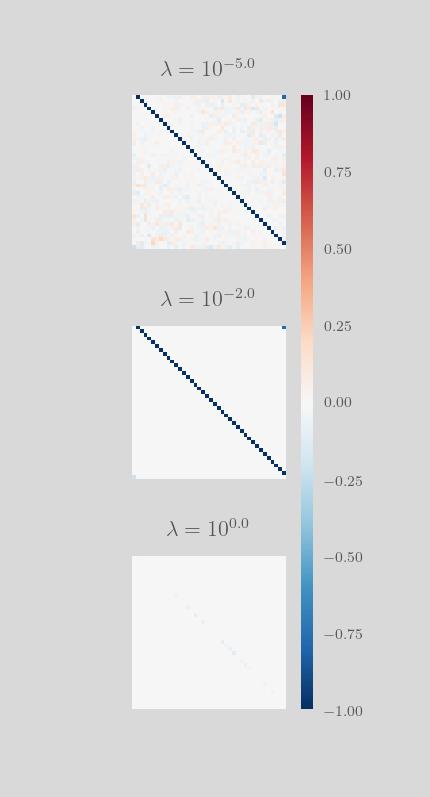

<IPython.core.display.Javascript object>


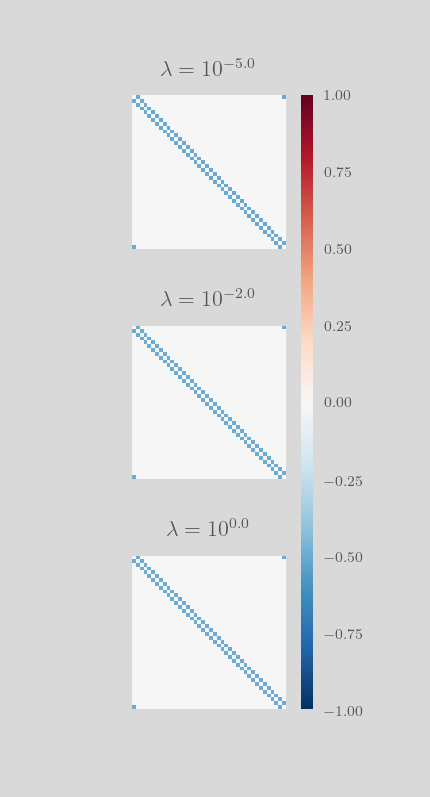

In [263]:
with plt.style.context('rapport'):
    fig, axes = coeff_plot(lasso)
    fig.savefig(fig_path / "lasso_coeff.png", dpi=300, transparent=True, bbox_inches='tight')
    fig, axes = coeff_plot(ridge)
    fig.savefig(fig_path / "ridge_coeff.png", dpi=300, transparent=True, bbox_inches='tight')

<IPython.core.display.Javascript object>


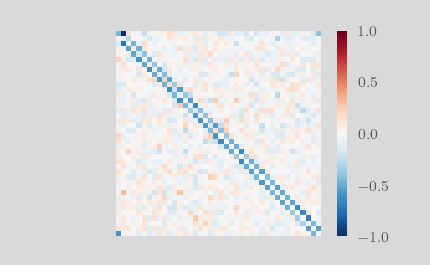

In [267]:
with plt.style.context('rapport'):
    fig, ax = plt.subplots()
    cmap_args = {'vmin': -1, 'vmax':1, 'cmap': "RdBu_r"}
    im = ax.matshow(cv_results.coeffs[0], **cmap_args)
    ax.axis('off')
    cax = fig.colorbar(im, ax=ax)
    cax.outline.set_linewidth(0)
    fig.savefig(fig_path / "lm_coeff.png", dpi=300, transparent=True, bbox_inches='tight')

In [102]:
def plot_best(models):
    means = np.asarray([np.mean(model.mse_test) for model in models])
    best = means.argmin()
    model = models[best]
    mean, std = model.average()
    fig, ax = plt.subplots(ncols=2)
    cmap_args = {'vmin': -1, 'vmax':1, 'cmap': "RdBu_r"}
    im = ax[0].matshow(mean, **cmap_args)
    ax[1].matshow(std, **cmap_args)
    fig.colorbar(im)
    return fig, ax

<IPython.core.display.Javascript object>


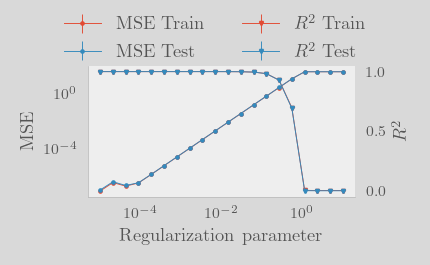

<IPython.core.display.Javascript object>


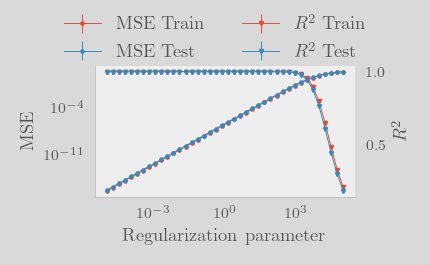

In [270]:
def mse_evolution(regrun, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.figure()
    #ax.plot(params, means)
    #ax.fill_between(params, means-se, means+se, alpha=0.3)
    ax.errorbar(regrun.parameters, regrun.train_mse, yerr=regrun.train_se_mse,
                fmt='.-', ms=3, linewidth=0.5,
               label=r'MSE Train')
    ax.errorbar(regrun.parameters, regrun.test_mse, yerr=regrun.test_se_mse, 
                fmt='.-', ms=3, linewidth=0.5,
               label=r'MSE Test')
    ax.set_ylabel('MSE')
    ax.set_xlabel('Regularization parameter')
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax2 = ax.twinx()
    #ax2.plot(params, means)
    #ax2.fill_between(params, means-se, means+se, alpha=0.3)
    #ax2.errorbar([1], [1])
    ax2.errorbar(regrun.parameters, regrun.train_r2, yerr=regrun.train_se_r2, 
                 fmt='v-', ms=2, linewidth=0.5,
                label=f'$R^2$ Train')
    ax2.errorbar(regrun.parameters, regrun.test_r2, yerr=regrun.test_se_r2, 
                 fmt='v-', ms=2, linewidth=0.5,
                label=f'$R^2$ Test')
    ax2.set_ylabel(r'$R^2$')
    fig.legend(loc=9, ncol=2, frameon=False)
    fig.tight_layout()
    fig.subplots_adjust(top=0.75)   
    return fig, ax
with plt.style.context('rapport'):
    fig, ax = mse_evolution(lasso)
    fig.savefig(fig_path / "lasso_reg.png", dpi=300, transparent=True, bbox_inches='tight')
    fig, ax = mse_evolution(ridge)
    fig.savefig(fig_path / "ridge_reg.png", dpi=300, transparent=True, bbox_inches='tight')
    #plt.show()